In [1]:
!pip install gensim seaborn wordcloud rank_bm25 nltk ktrain
!pip install git+https://github.com/lambdaofgod/mlutil

  Cloning https://github.com/lambdaofgod/mlutil to /tmp/pip-req-build-3falai4s
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhsp5twe/wheels/42/32/46/9616d5dd85e5dbc05ce3816dfa7dcedc052bc8b29442e1766a
Successfully built mlutil


In [2]:
import re
import tqdm
import requests

import numpy as np

from markdown import markdown
import nltk


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline

import rank_bm25

from mlutil import topic_modeling

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import bokeh.model
import bokeh.plotting
import bokeh.io
import re

import umap
from sklearn import metrics


bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))
    

def get_word_cloud(texts):
    text = ' '.join(texts)
    return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
    plt.figure(**figure_kwargs)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

  
def show_word_cloud_from_texts(text_column):
    texts = text_column.fillna('').values
    cloud = get_word_cloud(texts)
    show_word_cloud(cloud)

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [5]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [6]:
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
          object(expression: "master:README.md") {{
            ... on Blob {{
              text
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [7]:
def get_starred_repo_information():
    next_result = None
    starred_repo_information = []
    for __ in tqdm.tqdm(range(5)):
      next_result = get_next_paged_result(next_result)
      starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']
    return starred_repo_information

In [8]:
starred_repo_information = get_starred_repo_information()

100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


In [9]:
def get_cleaned_starred_repositories_df(repo_information, stemmer=nltk.stem.PorterStemmer()):
    repo_df = json_normalize(repo_information)
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['primaryLanguage'] = repo_df['primaryLanguage.name']
    repo_df.drop('primaryLanguage.name', axis=1)
    repo_df['topics'] = repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
    repo_df['topics'] = repo_df['topics'].apply(lambda ts: [stemmer.stem(t) for t in ts])
    repo_df['description'].fillna('', inplace=True)
    repo_df['description_stemmed'] = repo_df['description'].str.lower().apply(lambda s: stemmer.stem(re.sub('^[0-9a-zA-Z]+', '*' ,s)))
    repo_df['description_keywords'] = repo_df['description_stemmed'].apply(summarization.keywords)
    repo_df['description_length'] = repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l))
    repo_df = repo_df[repo_df['description_length'] > 0]
    return repo_df

In [10]:
def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [11]:
def plot_description_lengths(description_lengths):
    hist, edges = np.histogram(description_lengths.values, bins=25)
    median_description_length = description_lengths.median()
    mean_description_length = description_lengths.mean()

    p = bokeh.plotting.figure(
        title='Description length',
        x_axis_label='words in description',
        y_axis_label='number of repositories',
        plot_height=600, plot_width=800)
    p.quad(top=hist, left=edges[:-1], right=edges[1:], bottom=0)
    p.line([median_description_length, median_description_length], [0, 140], line_color='red')
    bokeh.plotting.show(p)

In [12]:
from bokeh import palettes


def plot_2d_data(data, text_label, cls, show_text=True, subset=None):
    palette = palettes.d3['Category20']
    x, y = data[:, 0], data[:, 1]
    source_df = pd.DataFrame({'x': x, 'y': y, 'text_label': text_label, 'color': [palette[c + 3][c] for c in cls]})
    source = bokeh.models.ColumnDataSource(source_df)

    TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,"
    
    p = bokeh.plotting.figure(tools=TOOLS, plot_width=1000, plot_height=800)
    p.scatter(x='x', y='y', source=source, fill_color='color', line_color='color')


    if subset is not None:
        text_labels = bokeh.models.LabelSet(x='x', y='y', text='text_label', level='glyph',
                      x_offset=5, y_offset=5, source=bokeh.models.ColumnDataSource(source_df.iloc[subset]), render_mode='canvas', text_font_size='7pt')
        p.add_layout(text_labels)
    bokeh.plotting.show(p)

In [13]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

/etc/anaconda/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


Primary language

In [14]:
language_counts = starred_repo_df['primaryLanguage'].fillna('unspecified').value_counts()

In [15]:
p = bokeh.plotting.figure(x_range=list(language_counts.index), title='Repository number by language')

p.vbar(x=language_counts.index, top=language_counts, width=1)
p.xaxis.major_label_orientation = "vertical"
bokeh.plotting.show(p)

In [16]:
plot_description_lengths(starred_repo_df['description_length'])

# Topics word cloud

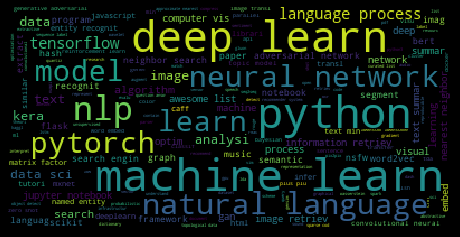

In [17]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

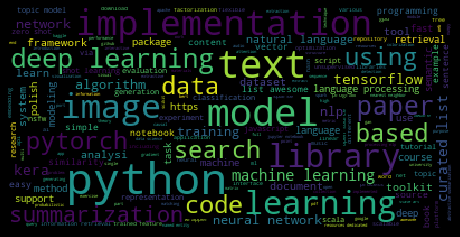

In [18]:
show_word_cloud_from_texts(starred_repo_df['description_stemmed'])

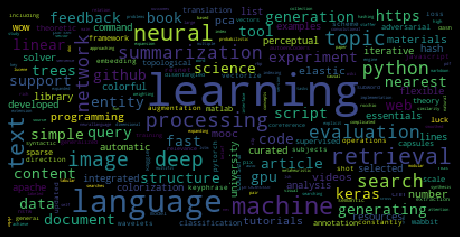

In [19]:
show_word_cloud_from_texts(starred_repo_df['description_keywords'])

## Term-document matrix

In [20]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words.ENGLISH_STOP_WORDS,
    ngram_range=(1,2)
)
term_document_matrix = vectorizer.fit_transform(starred_repo_df['description_stemmed'])

## Topic modeling (repo descriptions)

Note that term-document matrix is nonnegative - it contains (normalized) counts of words in documents.

In general a method that models documents as combinations of 'topics' which are combination of words is called a topic model.

One of the simplest ways to capture that is Nonnegative Matrix Factorization:

$$X \approx WH$$

Formally it solves minimization problem for

$$\|X - WH\|^2_F = \sum_{i, j}(X_{i,j} - (WH)_{i,j})^2 $$

Where $W$, $H$ are nonnegative.

In [21]:
import ktrain

num_topics = 10
tm = ktrain.text.get_topic_model(starred_repo_df['description_stemmed'], n_topics=num_topics, n_features=term_document_matrix.shape[1], lda_max_iter=50, min_df=3)

using Keras version: 2.2.4-tf
lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50


In [22]:
tm.build(starred_repo_df['description_stemmed'])

done.


In [23]:
tm.print_topics()

topic 0 | python image retrieval using information analysis library tool nsfw data
topic 1 | pdf download collection arxiv word feature detector analysi topics command
topic 2 | model based scala javascript similar popular variational related purescript new
topic 3 | search code toolkit training fast sentence topic simple semantic similarity
topic 4 | language pytorch nlp processing natural models polish dataset keras process
topic 5 | list curated awesome learn programming papers notebooks resources method tutorials
topic 6 | framework web easy scripts api wrapper examples nearest approximate github
topic 7 | implementation neural network tensorflow paper networks algorithm unsupervised research kera
topic 8 | text summarization https using document content classification evaluation extractive abstractive
topic 9 | learning deep machine library data science repository algorithms package methods


In [24]:
tm.print_topics(show_counts=True)

topic:9 | count:75 | learning deep machine library data science repository algorithms package methods
topic:0 | count:47 | python image retrieval using information analysis library tool nsfw data
topic:8 | count:36 | text summarization https using document content classification evaluation extractive abstractive
topic:7 | count:33 | implementation neural network tensorflow paper networks algorithm unsupervised research kera
topic:4 | count:32 | language pytorch nlp processing natural models polish dataset keras process
topic:3 | count:27 | search code toolkit training fast sentence topic simple semantic similarity
topic:5 | count:27 | list curated awesome learn programming papers notebooks resources method tutorials
topic:6 | count:14 | framework web easy scripts api wrapper examples nearest approximate github
topic:2 | count:5 | model based scala javascript similar popular variational related purescript new
topic:1 | count:3 | pdf download collection arxiv word feature detector analys

In [25]:
reduced_term_document_matrix = tm.predict(starred_repo_df['description_stemmed'])

In [26]:
reduced_term_document_matrix

array([[0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.15      ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.08333333, 0.08333333, 0.25      , ..., 0.08333333, 0.08333333,
        0.08333333],
       ...,
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.07208238, 0.0625    , 0.18740721, ..., 0.0625    , 0.0625    ,
        0.1875411 ],
       [0.0625    , 0.0625    , 0.0625    , ..., 0.0625    , 0.3125    ,
        0.1875    ]])

In [29]:
representative_repos = [get_repos_representing_topic(starred_repo_df, reduced_term_document_matrix, topic)[['description_stemmed']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

------
# Topic 1
------

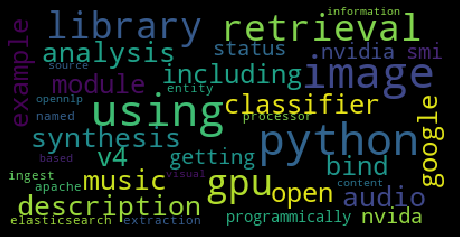

# Keywords

'python image retrieval using information analysis library tool nsfw data'

## **repositories representative for 1th topic:**

,description_stemmed
name,
essentia,"*++ library for audio and music analysis, desc..."
open-images,* an example image classifier using google ope...
gputil,* python module for getting the gpu status fro...
elasticsearch-ingest-opennlp,* elasticsearch ingest processor to do named e...
LIRE,* source library for content based image retri...


------
# Topic 2
------

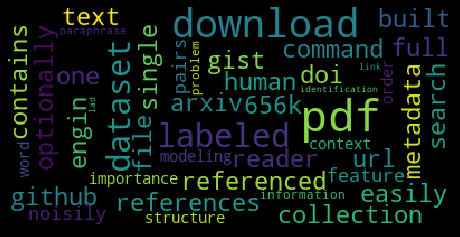

# Keywords

'pdf download collection arxiv word feature detector analysi topics command'

## **repositories representative for 2th topic:**

,description_stemmed
name,
pdfx,"* references (pdf, url, doi, arxiv) and metada..."
getgist,🖥️ easily download any file from a github gist...
mirusan,* pdf collection reader with built-in full-tex...
paws,"* dataset contains 108,463 human-labeled and 6..."
A-Large-scale-Attribute-Dataset-for-Zero-shot-Learning,* download link for the dataset lad.


------
# Topic 3
------

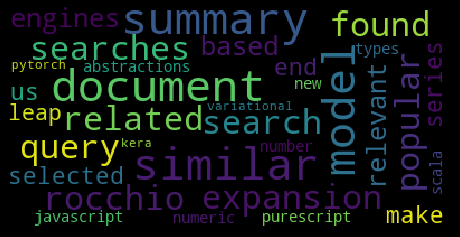

# Keywords

'model based scala javascript similar popular variational related purescript new'

## **repositories representative for 3th topic:**

,description_stemmed
name,
columbiau-rocchio-search-query-expander,"* rocchio query expansion - similar to ""relate..."
javascript-to-purescript,* series - make the leap from javascript to pu...
spire,* new number types and numeric abstractions fo...
nvdm,* variational document model
pytorch-summary,* summary in pytorch similar to `model.summary...


------
# Topic 4
------

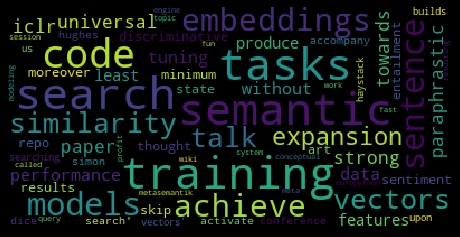

# Keywords

'search code toolkit training fast sentence topic simple semantic similarity'

## **repositories representative for 4th topic:**

,description_stemmed
name,
iclr2016,* code for training all models in the iclr pap...
VectorsInSearch,*.com repo to accompany the dice.com 'vectors ...
semanticMSE,* query expansion in semantic meta-search engi...
topic_modeling_tutorial,* & code for the europython 2014 training sess...
Fast_Sentence_Embeddings,* sentence embeddings fast!


------
# Topic 5
------

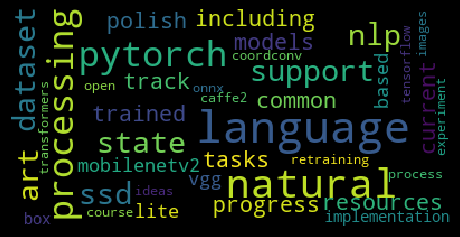

# Keywords

'language pytorch nlp processing natural models polish dataset keras process'

## **repositories representative for 5th topic:**

,description_stemmed
name,
NLP-progress,* to track the progress in natural language pr...
polish-nlp-resources,*-trained models and language resources for na...
pytorch-ssd,"*, mobilenetv2, vgg based ssd/ssd-lite impleme..."
transformers,🤗 transformers: state-of-the-art natural langu...
nlp_course,* course in natural language process


------
# Topic 6
------

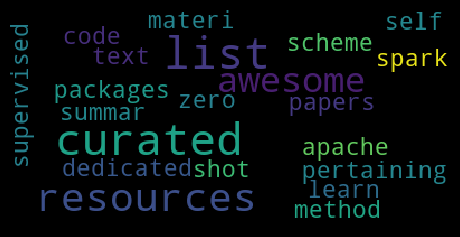

# Keywords

'list curated awesome learn programming papers notebooks resources method tutorials'

## **repositories representative for 6th topic:**

,description_stemmed
name,
awesome-spark,* curated list of awesome apache spark package...
awesome-zero-shot-learning,"* curated list of papers, code and resources p..."
awesome-scheme,* curated list of awesome scheme resources and...
awesome-self-supervised-learning,* curated list of awesome self-supervised method
awesome-text-summarization,* curated list of resources dedicated to text ...


------
# Topic 7
------

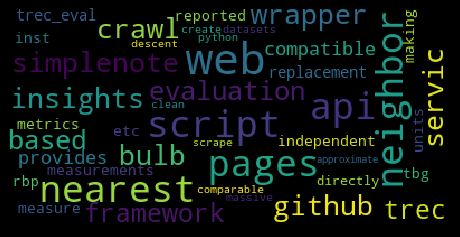

# Keywords

'framework web easy scripts api wrapper examples nearest approximate github'

## **repositories representative for 7th topic:**

,description_stemmed
name,
github-scraper,🕷 🕸 crawl github web pages for insights we can...
simplenote.py,* api wrapper for the simplenote web servic
cwl,* evaluation script based on the c/w/l framewo...
lazynlp,* to scrape and clean web pages to create mass...
pynndescent,* python nearest neighbor descent for approxim...


------
# Topic 8
------

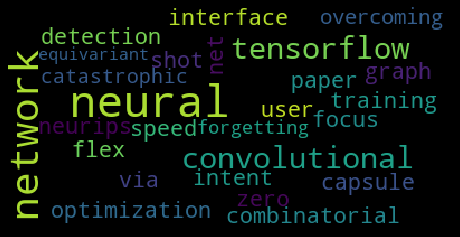

# Keywords

'implementation neural network tensorflow paper networks algorithm unsupervised research kera'

## **repositories representative for 8th topic:**

,description_stemmed
name,
ZeroShotCapsule,"* for paper ""zero-shot user intent detection v..."
learn2branch,* combinatorial optimization with graph convol...
tensorpack,"* neural net training interface on tensorflow,..."
overcoming-catastrophic,"* of ""overcoming catastrophic forgetting in ne..."
GrouPy,* equivariant convolutional neural network


------
# Topic 9
------

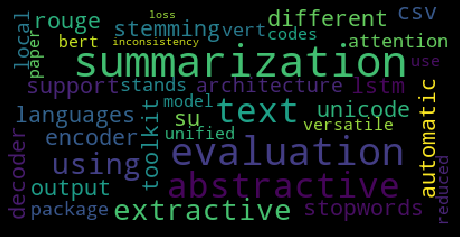

# Keywords

'text summarization https using document content classification evaluation extractive abstractive'

## **repositories representative for 9th topic:**

,description_stemmed
name,
ROUGE-2.0,* automatic summarization evaluation toolkit. ...
Abstractive-Summarization,* of abstractive summarization using lstm in t...
VertMetric,*: an abstractive summarization evaluation pac...
bert-extractive-summarizer,* to use extractive text summarization with bert
unified-summarization,* codes for the paper: a unified model for ext...


------
# Topic 10
------

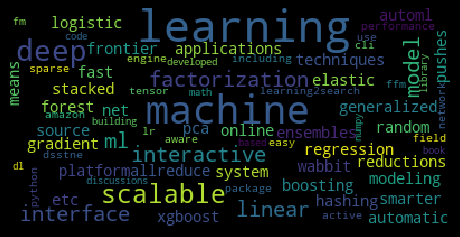

# Keywords

'learning deep machine library data science repository algorithms package methods'

## **repositories representative for 10th topic:**

,description_stemmed
name,
h2o-3,* source fast scalable machine learning platfo...
vowpal_wabbit,* wabbit is a machine learning system which pu...
xlearn,"* performance, easy-to-use, and scalable machi..."
amazon-dsstne,* scalable sparse tensor network engine (dsstn...
d2l-en,* into deep learning: an interactive deep lear...


In [30]:
topic_words = tm.get_topics()

for topic in range(num_topics):
    printmd("""------\n# Topic {}\n------""".format(topic+1))
    show_word_cloud_from_texts(representative_repos[topic]['description_stemmed'])
    printmd('# Keywords')
    display(topic_words[topic])
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

## Visualizing repository 2D projection

In [31]:
umap_red = umap.UMAP(metric='precomputed') 
umap_features = umap_red.fit_transform(metrics.pairwise.cosine_distances(reduced_term_document_matrix, reduced_term_document_matrix))

In [32]:
representatives = pd.concat(representative_repos)

In [33]:
representative_indices = np.where(starred_repo_df.index.isin(representatives.index))

In [34]:
plot_2d_data(
    umap_features,
    starred_repo_df.index,
    cls=np.argmax(reduced_term_document_matrix, axis=1),
    subset=representative_indices)

# Search

In [35]:
import rank_bm25 


class SearchEngine:
    
    def __init__(self, df, bm25_cls=rank_bm25.BM25Okapi, text_col='text'):
        self.bm25 = bm25_cls(df[text_col].str.split())
        self.df = df
        
    def search(self, query, k=100):
        scores = self.bm25.get_scores(query.split())
        #scores = scores[scores > 0]
        relevant_indices = np.argsort(-scores)[:k]
        return self.df.iloc[relevant_indices[scores[relevant_indices] > 0]]

In [36]:
search_engine = SearchEngine(starred_repo_df, text_col='description_stemmed')

In [37]:
search_engine.search('information retrieval')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_stemmed,description_keywords,description_length
name,,,,,,,,,,,
awesome-information-retrieval,A curated list of awesome information retrieva...,harpribot,NaN,[],# Awesome Information Retrieval [![Awesome](ht...,NaN,NaN,[],* curated list of awesome information retrieva...,retrieval,8
LIRE,Open source library for content based image re...,dermotte,Java,"[{'topic': {'name': 'image-retrieval'}}, {'top...",# LIRE - Lucene Image Retrieval\nLIRE (Lucene ...,Java,NaN,"[image-retriev, lire, multimedia]",* source library for content based image retri...,retrieval,12
pytrec_eval,pytrec_eval is an Information Retrieval evalua...,cvangysel,C++,"[{'topic': {'name': 'information-retrieval'}},...",pytrec_eval\n===========\n\npytrec\_eval is a ...,C++,NaN,"[information-retriev, evalu]",*_eval is an information retrieval evaluation ...,evaluation,14
query-expansion,Developing different methods for expanding a q...,phosseini,Python,[],# query-expansion\n\nThis repository is dedica...,Python,NaN,[],* different methods for expanding a query/topi...,query\nexpanding\nexpanded,19
SERT,Semantic Entity Retrieval Toolkit,cvangysel,Python,[{'topic': {'name': 'representation-learning'}...,Semantic Entity Retrieval Toolkit\n===========...,Python,NaN,"[representation-learn, deeplearn, neural-netwo...",* entity retrieval toolkit,,4
dit,Python package for information theory.,dit,Python,"[{'topic': {'name': 'python'}}, {'topic': {'na...",NaN,Python,NaN,"[python, information-theori]",* package for information theory.,,5
ir-python,A python implementation for information retrie...,zxzlogic,Python,[],# ir-python\nA python implementation for infor...,Python,NaN,[],* python implementation for information retrie...,retrieval\npython\nindex\nindexing\nkey,34
irlib,Information Retrieval Library (in Python),gr33ndata,Python,[],NaN,Python,NaN,[],* retrieval library (in python),,5
musicinformationretrieval.com,Instructional notebooks on music information r...,stevetjoa,Jupyter Notebook,"[{'topic': {'name': 'ipython-notebook'}}, {'to...",stanford-mir\n============\n\n[![Stories in Re...,Jupyter Notebook,NaN,"[ipython-notebook, music-information-retriev, ...",* notebooks on music information retrieval.,,6


# Using Transformers

In [ ]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
roberta.eval()  # disable dropout (or leave in train mode to finetune)

In [ ]:
%%time
def get_roberta_features(text):
    return roberta.extract_features(roberta.encode(text)).detach().numpy()[0]

description_roberta_features = starred_repo_df['description'].apply(get_roberta_features)

In [ ]:
class EmbeddingSearchEngine:
    
    def __init__(self, embedder, texts=None, features=None):
        self.embedder = embedder
        if features == None:
            self.features = list(map(partial(get_embedder_features, embedder=embedder))))
        
    def search()

In [ ]:
n = len(description_roberta_features)
description_distances = np.zeros((n, n))

In [ ]:
from sklearn import metrics
import ot

In [ ]:
def get_optimal_transport_distance(v, w, sinkhorn_method='sinkhorn_stabilized'):
    dists = metrics.pairwise.euclidean_distances(v, w) ** 2
    transport = ot.sinkhorn([], [], dists, 0.1, method=sinkhorn_method, numItermax=100)
    cost = (dists * transport).sum()
    return cost 

In [ ]:
v = description_roberta_features[0] 
w = description_roberta_features[1] 

In [ ]:
%%timeit 
get_optimal_transport_distance(v, w)

In [ ]:
from concurrent.futures import ProcessPoolExecutor

In [ ]:
pool = ProcessPoolExecutor()

ds = []
for i in tqdm.tqdm(range(n)):
    v = description_roberta_features[i]
    def _map_fn(w):
        return get_optimal_transport_distance(v, w)
    v_distances = pool.map(_map_fn, [description_roberta_features[j] for j in range(i, n)], chunksize=10)
    ds.append(np.array(list(v_distances)))

In [ ]:
distances = np.zeros((n, n))
for i, d in enumerate(ds):
    distances[i, i:] = d
distances = distances + distances.T

In [ ]:
sns.heatmap(distances)

In [ ]:
roberta_mds = manifold.MDS(n_components=2, metric='precomputed')

roberta_mds_features = roberta_mds.fit_transform(distances)

In [ ]:
plot_2d_data(roberta_mds_features[representative_indices], starred_repo_df.index[representative_indices])